# QUANTITATIVE TRADING STRATEGIES - HW 4

## Return Predictions From Trade Flow

**Name**: Adriana Mata

**Date**: 30/01/2024

**Table of Contents:**

1. Introduction
2. Data Manipulation

    * 2.1. Data Extraction
    * 2.2. Data Validation

.

3. Strategy

4. Analysis

5. Conclusions

# 1. Introduction 

In this project, we will asses the trade flow as means of generating profit opportunities in 3 different cryptotoken markets. The opportunity at high data rates like these, and given the markets’ price-time priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably into the fray.


### Order Book and Trade Marking

In financial markets, the order book serves as a crucial mechanism for matching buyers and sellers, facilitating the exchange of assets at agreed-upon prices. Within the order book, bids and asks represent the respective prices at which buyers and sellers are willing to transact. Market participants can adjust their bids and asks based on evolving market conditions, seeking optimal outcomes for their positions. The mid price, derived as the average of the bid and ask prices, provides a snapshot of the prevailing market value of the asset.

Observations from market experts have revealed intriguing dynamics governing trading behavior:

1. **Imbalance between bids and asks**: When the number of asks significantly outweighs bids (or vice versa), the clearing price tends to gravitate closer to the bid price than the mid price. This phenomenon reflects the willingness of participants to adjust their pricing expectations based on prevailing supply and demand dynamics.

2. **Directional trading activity**: A notable trend emerges when many traders execute transactions that cross the spread in the same direction, either from bid to ask or vice versa. Such consistent directional trading suggests the presence of informed participants with specific insights driving their trading decisions, as opposed to noise traders lacking actionable information.

These observations prompt speculation regarding potential serial correlations between trading patterns and subsequent asset price movements. To further explore this relationship, the concept of trade marking is introduced. Trade marking involves categorizing trades as either "seller-initiated," "buyer-initiated," or "mid price," based on the following process:

1. Identify the best bid and ask prices within the order book.
2. Compare the trade price to these best bid and ask prices.
3. If the trade price matches the best bid price, the trade is marked as "seller-initiated."
4. If the trade price matches the best ask price, the trade is marked as "buyer-initiated."
5. If neither of the above rules applies, the trade is marked as occurring at the "mid price."

By applying trade marking techniques, analysts can gain insights into the prevailing sentiment and directionality of trading activity within the market. This understanding lays the groundwork for further exploration of potential correlations between trade flow patterns and subsequent asset price changes, offering valuable insights for traders and investors navigating dynamic financial markets.

### Trade Flow Analysis and Return Predictions

**Trade Flow** serves as a crucial metric in understanding market dynamics, representing a cumulative record of signed trade sizes categorized by buyer-initiated and seller-initiated trades. In this framework, trades initiated by sellers are assigned a sign of -1, while trades initiated by buyers are assigned a sign of 1. The trade flow within a defined time period is computed as the volume of buyer-initiated trades subtracted from the volume of seller-initiated trades.

The underlying intuition behind this approach lies in the observation that significant activity across the market-making spread indicates the presence of informed directional traders. When multiple traders execute transactions that cross the spread simultaneously, it suggests the incorporation of new information into market prices, potentially driving future price movements.

Prediction and **returns** analysis further leverage trade flow data to inform trading strategies. By employing linear regression techniques, analysts can quantify the correlation between trade flow and subsequent returns. This involves computing the regression of trade flow against returns, allowing for the assessment of the predictive power of trade flow as a signal.

The return of the strategy is determined by the spread of log returns between the entry and exit prices of a position held for a specified time interval, denoted as T. By strategically selecting T, traders can optimize their trading strategy to capture potential market inefficiencies and maximize returns.

# 2. Data Manipulation

## 2.1. Data Extraction

Before starting the data extraction, it is necessary to ensure that the required libraries are imported into the Jupyter Notebook file. These libraries, such as Pandas, NumPy, Matplotlib, among others, will be very useful to reduce the length of the code and make tasks more efficient.


In [591]:
import os
import datetime
import quandl

import pandas as pd
import numpy as np
import scipy as sp
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

import scipy.stats as stats
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In order to import multiple files that have similar filenames except for a specific part that changes, we will use a loop to iterate through the different parts that change, modify the file path accordingly, and load each file into a DataFrame. Then, we will store each DataFrame in a dictionary where the key is a meaningful identifier.

In [554]:
base_paths = ['../Homework/Crypto_Data/book_narrow_', '../Homework/Crypto_Data/trades_narrow_']
crypto = ['BTC-USD', 'ETH-USD', 'ETH-BTC']

# Dictionary to store dataframes
dataframes = {}

for base_path in base_paths:
    for c in crypto:
        # Construct file path
        file_path = f'{base_path}{c}_2023.delim'
        
        # Read the file into a DataFrame
        df = pd.read_csv(file_path, sep='\t')
        
        # Determine the type of data based on the base path
        data_type = 'book' if 'book_narrow' in base_path else 'trades'

        # Replace hyphens with underscores in the currency code
        c_formatted = c.replace('-', '_')
        
        # Store the DataFrame in the dictionary with a meaningful key
        key = f'{data_type}_{c_formatted}' # This will be like 'book_BTC-USD' or 'trades_BTC-USD'
        dataframes[key] = df


Check all the files generated and their respective names

In [555]:
for key, df in dataframes.items():
    # Print the name of the DataFrame (key)
    print(f'DataFrame Name: {key}')

DataFrame Name: book_BTC_USD
DataFrame Name: book_ETH_USD
DataFrame Name: book_ETH_BTC
DataFrame Name: trades_BTC_USD
DataFrame Name: trades_ETH_USD
DataFrame Name: trades_ETH_BTC


Finally, we will extract the files from the `Dataframes dictionary` for a better manipulation.

In [556]:
for key in dataframes:
    globals()[key] = dataframes[key]


Here, the received time comes from the clock of the recording device, which was not synchronized to the exchange clock. Such inaccuracies in clock settings, i.e. “clock skew”, can cause exchange timestamps to appear later than the time at which they are recorded as having been received.

As noted in class, exchange timestamps are not actionable, in the sense that any market participant would not see the data until considerably later. On the other hand, received timestamps, while actionable, may be subject to poor recording techniques on the client side. For this homework you may choose either, but I recommend the exchange timestamps.


## 2.2. Data Validation

The final step in this section involves validating the computed data against the values provided in the accompanying PDF file. As it can be seen the format of the data matches with the one provided in the **'HW4_FlowCryptoAlphaOpportunity.pdf'**. 

**Trades**

In [557]:
trades_BTC_USD.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521267814309000,1674521267874527000,22970120000,87069600,-1
1,1674521267814046000,1674521267874527000,22970150000,25797600,-1
2,1674521267817981000,1674521267878712000,22970120000,10,-1
3,1674521267822734000,1674521267886114000,22969160000,217683140,-1
4,1674521274845338000,1674521268676444000,22969840000,10000000,1


**Book**

In [558]:
book_BTC_USD.head().T

,0,1,2,3,4
Ask1PriceMillionths,2.297255e+10,2.297255e+10,2.297255e+10,2.297254e+10,2.297254e+10
Bid1PriceMillionths,2.297015e+10,2.297015e+10,2.297015e+10,2.297015e+10,2.297015e+10
Ask1SizeBillionths,2.100000e+08,4.100000e+08,4.100000e+08,2.100000e+08,2.100000e+08
Bid1SizeBillionths,2.579760e+07,2.579760e+07,2.579760e+07,2.579760e+07,2.579760e+07
Ask2PriceMillionths,2.297256e+10,2.297256e+10,2.297256e+10,2.297255e+10,2.297255e+10
Bid2PriceMillionths,2.297012e+10,2.297012e+10,2.297012e+10,2.297012e+10,2.297012e+10
Ask2SizeBillionths,2.100000e+08,2.100000e+08,2.100000e+08,4.100000e+08,4.100000e+08
Bid2SizeBillionths,8.706961e+07,8.706961e+07,8.706961e+07,8.706961e+07,8.706961e+07
received_utc_nanoseconds,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18
timestamp_utc_nanoseconds,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18


In [ ]:
def normalize_and_rename(df):
    """
    Normalizes the 'SizeBillionths' and 'PriceMillionths' columns by dividing them
    by 10^9 and 10^6 respectively, and renames them to 'Size' and 'Price'.

    Inputs:
        df: pd.DataFrame containing the columns 'SizeBillionths' and 'PriceMillionths'.

    Outputs:
        pd.DataFrame with the normalized and renamed columns.
    """
    df_copy = df.copy()

    df_copy['Size'] = df_copy['SizeBillionths'] / 10**9
    df_copy['Price'] = df_copy['PriceMillionths'] / 10**6

    df_copy.drop(columns=['SizeBillionths', 'PriceMillionths'], inplace=True)
    
    return df_copy

**Analysis on the data** 

This analysis will help us understand the data before building the strategy

In [626]:
data_analysis_ETH_BTC  = trades_ETH_BTC.copy()
data_analysis_ETH_BTC = normalize_and_rename(data_analysis_ETH_BTC)
data_analysis_ETH_BTC.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,Side,F_tau,Size,Price
timestamp,,,,,,
2023-01-24 00:49:06.020758,1674521345955989000,1674521346020758000,1,0.0,0.259657,0.07095
2023-01-24 00:49:06.050573,1674521345984460000,1674521346050573000,1,-259656510.0,0.000141,0.07095
2023-01-24 00:49:08.159815,1674521348097555000,1674521348159815000,-1,-259797310.0,0.053583,0.07095
2023-01-24 00:49:12.601911,1674521352535174000,1674521352601911000,-1,-313379860.0,0.000207,0.07094
2023-01-24 00:52:26.201920,1674521546128872000,1674521546201920000,1,0.0,0.000991,0.07095


The first graph represents a price time series plot which depicts the price of ETH_BTC over time to visualize price trends.

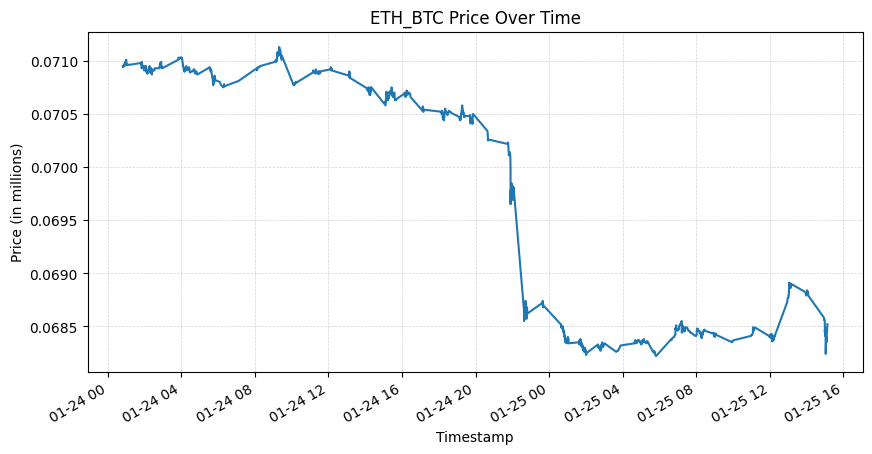

In [628]:
data_analysis_ETH_BTC['Price'].plot(title='ETH_BTC Price Over Time', figsize=(10, 5))
plt.xlabel('Timestamp')
plt.ylabel('Price (in millions)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

Secondly, we will plot a trade size time series plot to illustrate the trading size trends over time to observe any potential spikes indicating large transactions.

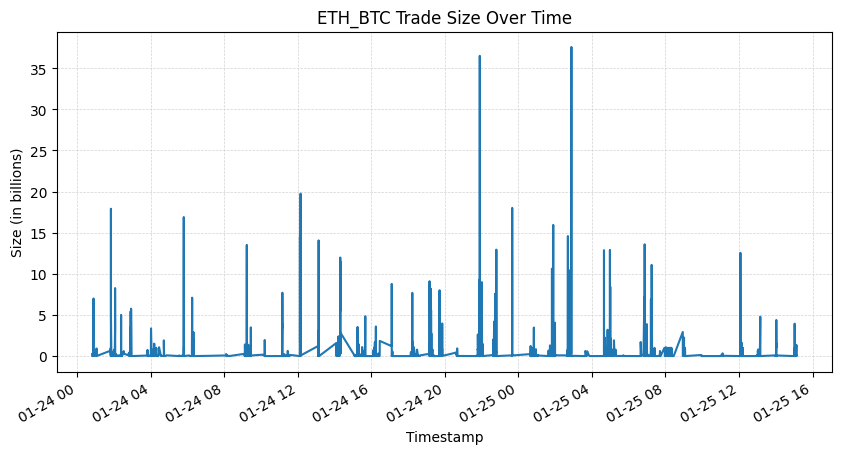

In [631]:
data_analysis_ETH_BTC['Size'].plot(title='ETH_BTC Trade Size Over Time', figsize=(10, 5))
plt.xlabel('Timestamp')
plt.ylabel('Size (in billions)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

Thirdly, we will compute an order size distribution by side and we will overlaid two histograms to visualize the distribution of order sizes for buys and sells

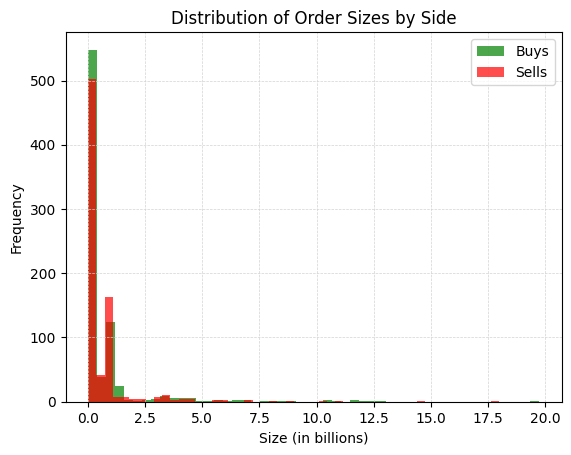

In [632]:
data_analysis_ETH_BTC[data_analysis_ETH_BTC['Side'] == 1]['Size'].hist(bins=50, alpha=0.7, label='Buys', color='green')
data_analysis_ETH_BTC[data_analysis_ETH_BTC['Side'] == -1]['Size'].hist(bins=50, alpha=0.7, label='Sells', color='red')
plt.title('Distribution of Order Sizes by Side')
plt.xlabel('Size (in billions)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()


Finally, it could be interesting to know when most of the trades happen, that is why we will generate a plot to see when all the trades happen within one day time frame. 

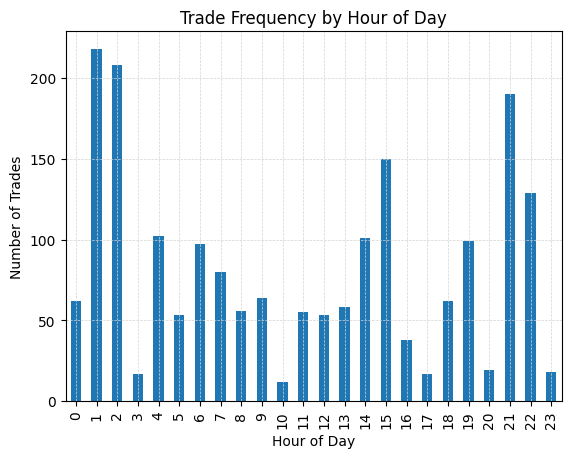

In [635]:
data_analysis_ETH_BTC.index.hour.value_counts().sort_index().plot(kind='bar', title='Trade Frequency by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trades')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()


## 3. Strategy

This trading strategy entails a series of steps aimed at leveraging trade flow data to predict future returns and inform trading decisions:

1. **Calculate Trade Flow ($F^{(\tau)}_i$):** Compute the trade flow $F^{(\tau)}_i$ for each time period $\tau$, where $F^{(\tau)}_i$ represents the difference between the volume of buyer-initiated trades and the volume of seller-initiated trades.

2. **Compute T-second Forward Returns ($r^{(T)}_{i}$):** Calculate the T-second forward returns $r^{(T)}_{i}$ for each trading period. These returns represent the spread between the entry and exit prices of a position held for a specified time interval T.

3. **Regression Analysis:** Perform linear regression of $r^{(T)}_{i}$ against $F^{(\tau)}_i$ to quantify the relationship between trade flow and future returns. This step aims to determine the predictive power of trade flow as a signal for forecasting returns.

4. **Predict Returns for the Test Set ($\hat{r}_i$):** Utilize the regression coefficients ($\beta$) obtained from step 3 to predict future returns for the test set. The predicted returns $\hat{r}_i$ are computed as the dot product of $\beta$ and $F^{(\tau)}_i$.

5. **Trading Thresholds:** Define thresholds for $j$ based on the predicted returns $\hat{r}_i$. These thresholds indicate the level at which trading signals are triggered. For example, trading may be initiated whenever $j$ is less than the absolute value of the predicted returns $\tilde{r}_i$.

By following these steps, traders can systematically analyze trade flow data, identify potential trading opportunities based on predicted returns, and implement trading strategies to capitalize on market inefficiencies and maximize returns. This approach integrates quantitative analysis with trading decision-making, offering a structured framework for navigating financial markets.

**Step 1: Calculate $F^{(\tau)}_i$**

The function `calculate_trade_flow` computes the trade flow for each trade within a specified time interval (tau). It sorts the DataFrame by timestamp and iterates through each trade, calculating the trade flow as the sum of signed trade sizes within the interval. Positive values represent seller-initiated trades, while negative values represent buyer-initiated trades. Finally, it assigns the calculated trade flow to each trade's 'F_tau' column in the DataFrame.

In [559]:
def calculate_trade_flow(trades_df, tau):

    tau_ns = tau * 1e9

    trades_df.sort_values(by='timestamp_utc_nanoseconds', inplace=True)    
    trades_df['F_tau'] = 0.0

    for i in range(len(trades_df)):
        current_timestamp = trades_df.iloc[i]['timestamp_utc_nanoseconds']
        
        # Define the start of the interval
        start_interval = current_timestamp - tau_ns
        
        interval_trades = trades_df[(trades_df['timestamp_utc_nanoseconds'] >= start_interval) & 
                                    (trades_df['timestamp_utc_nanoseconds'] < current_timestamp)]
        
        # Calculate the flow as the sum of signed trade sizes
        # Assign positive values for seller-initiated trades and negative for buyer-initiated trades
        F_tau = interval_trades.apply(
            lambda x: x['SizeBillionths'] if x['Side'] == 'sell' else -x['SizeBillionths'], axis=1
        ).sum()
        
        # Assign the computed F(tau) to the current trade's 'F_tau' column
        trades_df.at[i, 'F_tau'] = F_tau

    return trades_df

**ETH_BTC**

In [560]:
trades_ETH_BTC = calculate_trade_flow(trades_ETH_BTC, tau = 60)

A new column `F_tau` has been created

In [564]:
trades_ETH_BTC.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side,F_tau
0,1674521345955989000,1674521346020758000,70950,259656510,1,0.0
1,1674521345984460000,1674521346050573000,70950,140800,1,-259656510.0
2,1674521348097555000,1674521348159815000,70950,53582550,-1,-259797310.0
3,1674521352535174000,1674521352601911000,70940,207220,-1,-313379860.0
4,1674521546128872000,1674521546201920000,70950,990630,1,0.0


**BTC_USD**

In [562]:
trades_BTC_USD = calculate_trade_flow(trades_BTC_USD, tau = 60)

**ETH_USD**

In [643]:
trades_ETH_USD = calculate_trade_flow(trades_ETH_USD, tau = 60)

The following code regulates all the trades timestamps. It first converts the 'timestamp_utc_nanoseconds' in the `trades_ETH_BTC` DataFrame to datetime, sets it as the index, aggregates the data by the last and mean values of specified columns, and regularizes the time series to a fixed interval of T seconds. Then, it forward-fills missing values for these regular intervals to create a continuous time series, ensuring data consistency across regular timestamps. Finally, it plots the original and regularized 'F_tau' values, highlighting the regularized data points in red and marking each regular timestamp with a vertical gray line.

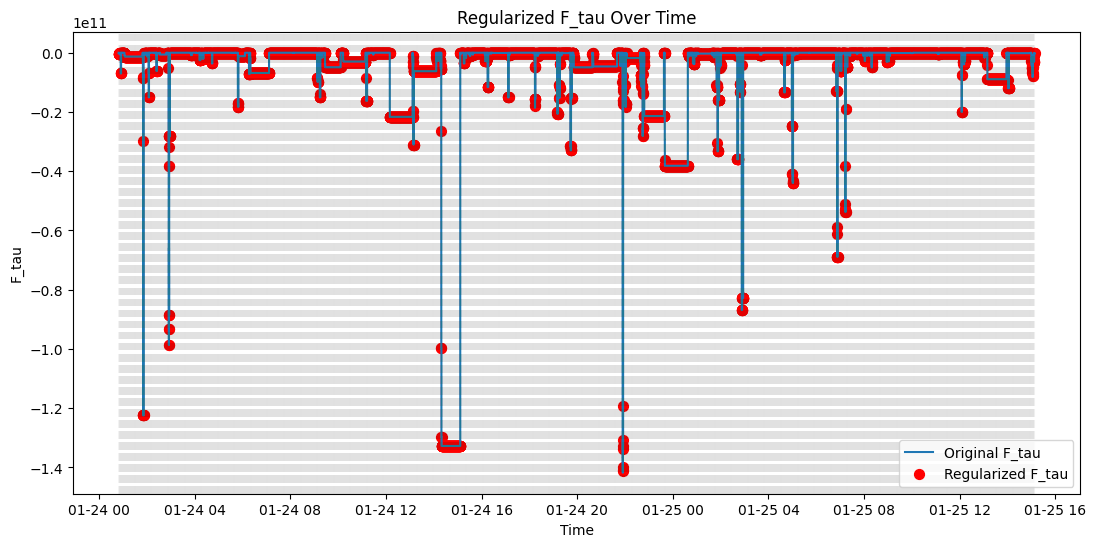

In [565]:
T = 10

trades_ETH_BTC['timestamp'] = pd.to_datetime(trades_ETH_BTC['timestamp_utc_nanoseconds'], unit='ns')
trades_ETH_BTC.set_index('timestamp', inplace=True)

aggregation_methods = {
    'F_tau': 'mean',  # mean for F_tau
    'PriceMillionths': 'last',  # last value for PriceMillionths
    'SizeBillionths': 'last',  # last value for SizeBillionths
    'Side': 'last'  # last value for Side
}

# Remove duplicates by aggregating the columns
trades_ETH_BTC_agg = trades_ETH_BTC.groupby('timestamp').agg(aggregation_methods)

# Assuming we want to sample every T seconds
reg_dt = pd.to_timedelta(T, unit='s')

# Generate regular timestamps starting from the first timestamp in your data, spaced by reg_dt
reg_ts = pd.date_range(start=trades_ETH_BTC_agg.index.min(), end=trades_ETH_BTC_agg.index.max(), freq=reg_dt)

# Forward-fill the values to the regular timestamps
joined_with_NA = trades_ETH_BTC_agg.reindex(reg_ts.union(trades_ETH_BTC_agg.index)).ffill()

# Sample the regular timestamps
regular_values = joined_with_NA.loc[reg_ts]

plt.figure(figsize=(13, 6))
plt.step(trades_ETH_BTC_agg.index, trades_ETH_BTC_agg['F_tau'], where='post', label='Original F_tau')
plt.scatter(regular_values.index, regular_values['F_tau'], color='red', s=50, label='Regularized F_tau')

for t in regular_values.index:
    plt.axvline(t, color='gray', linestyle='--', alpha=0.005)

plt.title('Regularized F_tau Over Time')
plt.legend()
plt.xlabel('Time')
plt.ylabel('F_tau')
plt.show()

In [566]:
trades_ETH_BTC_agg.head()

,F_tau,PriceMillionths,SizeBillionths,Side
timestamp,,,,
2023-01-24 00:49:06.020758,0.0,70950,259656510,1
2023-01-24 00:49:06.050573,-259656510.0,70950,140800,1
2023-01-24 00:49:08.159815,-259797310.0,70950,53582550,-1
2023-01-24 00:49:12.601911,-313379860.0,70940,207220,-1
2023-01-24 00:52:26.201920,0.0,70950,990630,1


**BTC_USD**

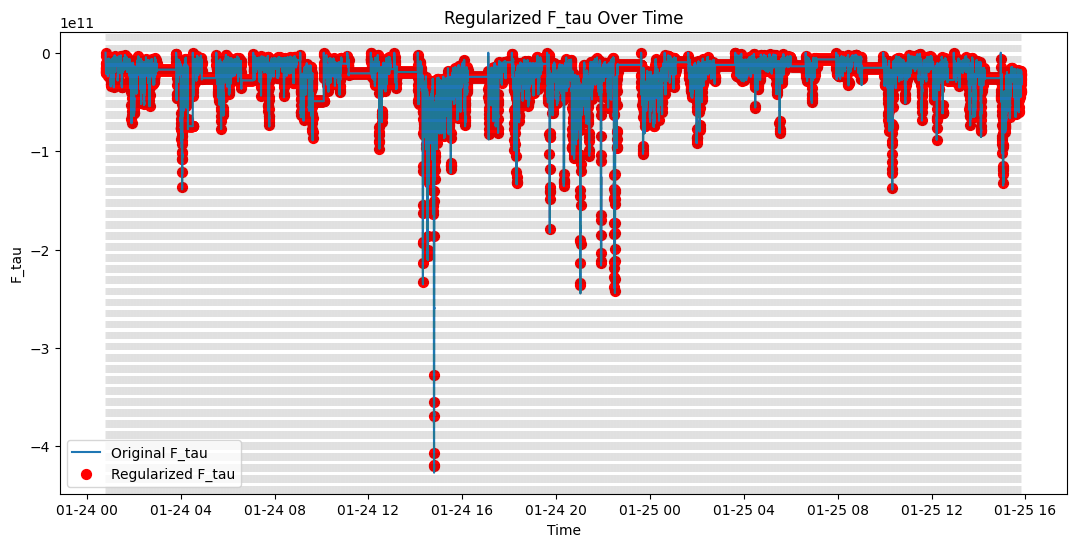

In [606]:
T = 10

trades_BTC_USD['timestamp'] = pd.to_datetime(trades_BTC_USD['timestamp_utc_nanoseconds'], unit='ns')
trades_BTC_USD.set_index('timestamp', inplace=True)

aggregation_methods = {
    'F_tau': 'mean',  # mean for F_tau
    'PriceMillionths': 'last',  # last value for PriceMillionths
    'SizeBillionths': 'last',  # last value for SizeBillionths
    'Side': 'last'  # last value for Side
}

# Remove duplicates by aggregating the columns
trades_BTC_USD_agg = trades_BTC_USD.groupby('timestamp').agg(aggregation_methods)

# Assuming we want to sample every T seconds
reg_dt = pd.to_timedelta(T, unit='s')

# Generate regular timestamps starting from the first timestamp in your data, spaced by reg_dt
reg_ts = pd.date_range(start=trades_BTC_USD_agg.index.min(), end=trades_BTC_USD_agg.index.max(), freq=reg_dt)

# Forward-fill the values to the regular timestamps
joined_with_NA = trades_BTC_USD_agg.reindex(reg_ts.union(trades_BTC_USD_agg.index)).ffill()

# Sample the regular timestamps
regular_values = joined_with_NA.loc[reg_ts]

plt.figure(figsize=(13, 6))
plt.step(trades_BTC_USD_agg.index, trades_BTC_USD_agg['F_tau'], where='post', label='Original F_tau')
plt.scatter(regular_values.index, regular_values['F_tau'], color='red', s=50, label='Regularized F_tau')

for t in regular_values.index:
    plt.axvline(t, color='gray', linestyle='--', alpha=0.005)

plt.title('Regularized F_tau Over Time')
plt.legend()
plt.xlabel('Time')
plt.ylabel('F_tau')
plt.show()

In [608]:
trades_BTC_USD_agg.head()

,F_tau,PriceMillionths,SizeBillionths,Side,forward_return
timestamp,,,,,
2023-01-24 00:47:47.874527,0.0,22970150000,25797600,-1,0.000048
2023-01-24 00:47:47.878712,-112867200.0,22970120000,10,-1,0.000050
2023-01-24 00:47:47.886114,-112867210.0,22969160000,217683140,-1,0.000091
2023-01-24 00:47:48.676444,-330550350.0,22969900000,123178530,1,0.000148
2023-01-24 00:47:48.812951,-602285400.0,22967670000,1318360,-1,0.000246


**ETH_USD**

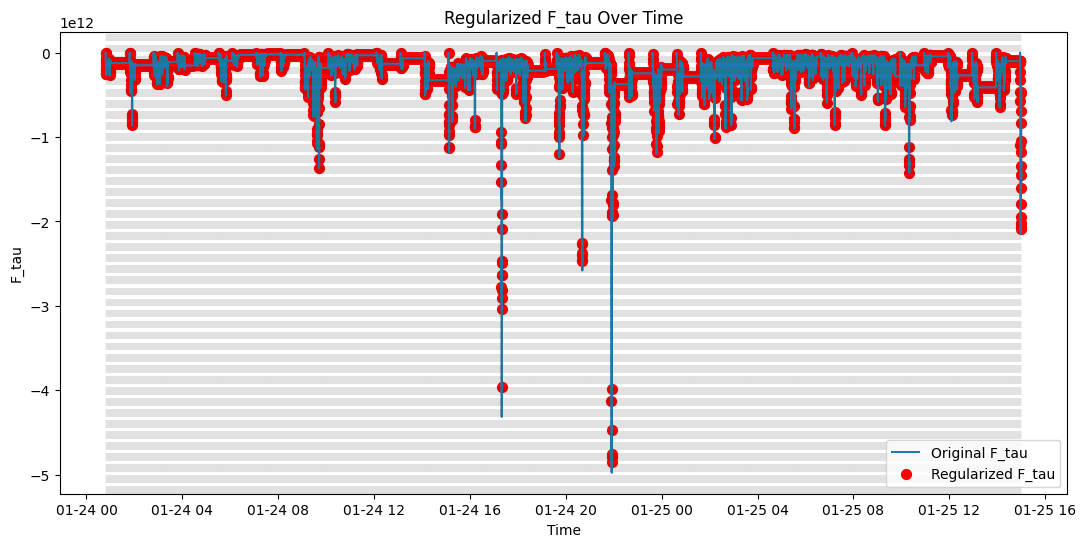

In [644]:
T = 10

trades_ETH_USD['timestamp'] = pd.to_datetime(trades_ETH_USD['timestamp_utc_nanoseconds'], unit='ns')
trades_ETH_USD.set_index('timestamp', inplace=True)

aggregation_methods = {
    'F_tau': 'mean',  # mean for F_tau
    'PriceMillionths': 'last',  # last value for PriceMillionths
    'SizeBillionths': 'last',  # last value for SizeBillionths
    'Side': 'last'  # last value for Side
}

# Remove duplicates by aggregating the columns
trades_ETH_USD_agg = trades_ETH_USD.groupby('timestamp').agg(aggregation_methods)

# Assuming we want to sample every T seconds
reg_dt = pd.to_timedelta(T, unit='s')

# Generate regular timestamps starting from the first timestamp in your data, spaced by reg_dt
reg_ts = pd.date_range(start=trades_ETH_USD_agg.index.min(), end=trades_ETH_USD_agg.index.max(), freq=reg_dt)

# Forward-fill the values to the regular timestamps
joined_with_NA = trades_ETH_USD_agg.reindex(reg_ts.union(trades_ETH_USD_agg.index)).ffill()

# Sample the regular timestamps
regular_values = joined_with_NA.loc[reg_ts]

plt.figure(figsize=(13, 6))
plt.step(trades_ETH_USD_agg.index, trades_ETH_USD_agg['F_tau'], where='post', label='Original F_tau')
plt.scatter(regular_values.index, regular_values['F_tau'], color='red', s=50, label='Regularized F_tau')

for t in regular_values.index:
    plt.axvline(t, color='gray', linestyle='--', alpha=0.005)

plt.title('Regularized F_tau Over Time')
plt.legend()
plt.xlabel('Time')
plt.ylabel('F_tau')
plt.show()

In [645]:
trades_ETH_USD_agg.head()

,F_tau,PriceMillionths,SizeBillionths,Side
timestamp,,,,
2023-01-24 00:47:51.071902,0.000000e+00,1629670000,11815210,-1
2023-01-24 00:47:51.398509,-1.181521e+07,1629790000,1016994240,2
2023-01-24 00:47:51.578052,-1.833563e+09,1629770000,92150000,1
2023-01-24 00:47:51.660995,-1.925713e+09,1629820000,613551310,1
2023-01-24 00:47:51.885174,-2.539273e+09,1629970000,479985270,1


**Step 2: Compute T-second forward returns $r^{(T)}_{i}$**

The function `calculate_forward_returns` computes the T-second forward returns for each trade. It iterates through each trade and locates the subsequent trade occurring T seconds later. If such a trade exists, it calculates the forward return as the percentage change between the future trade's price and the current trade's price. Finally, it assigns the calculated forward returns to each trade's 'forward_return' column in the DataFrame.

In [567]:
def calculate_forward_returns(trades_df, T_sec):
    T = T_sec * 1e9  # Convert seconds to nanoseconds
    trades_df['forward_return'] = 0.0  # Initialize the forward_return column
    
    # Convert the timestamp from nanoseconds to a datetime64[ns] type for comparison
    trades_df.index = pd.to_datetime(trades_df.index, unit='ns')
    
    for i in range(len(trades_df)):
        current_time = trades_df.index[i]
        future_time = current_time + pd.Timedelta(nanoseconds=T)
        # Locate the future trade
        future_trade = trades_df[trades_df.index >= future_time].head(1)
        if not future_trade.empty:
            current_price = trades_df.iloc[i]['PriceMillionths']
            future_price = future_trade['PriceMillionths'].iloc[0]
            # Calculate return
            trades_df.at[trades_df.index[i], 'forward_return'] = (future_price - current_price) / current_price
    
    return trades_df


A new column `forward_return` has been created

In [568]:
calculate_forward_returns(trades_ETH_BTC_agg, T_sec = 10)

,F_tau,PriceMillionths,SizeBillionths,Side,forward_return
timestamp,,,,,
2023-01-24 00:49:06.020758,0.000000e+00,70950,259656510,1,0.000000
2023-01-24 00:49:06.050573,-2.596565e+08,70950,140800,1,0.000000
2023-01-24 00:49:08.159815,-2.597973e+08,70950,53582550,-1,0.000000
2023-01-24 00:49:12.601911,-3.133799e+08,70940,207220,-1,0.000141
2023-01-24 00:52:26.201920,0.000000e+00,70950,990630,1,0.000141
...,...,...,...,...,...
2023-01-25 15:07:00.556309,-2.853522e+09,68470,170840,-1,0.000146
2023-01-25 15:07:13.932491,-1.493508e+08,68480,83190000,-1,0.000146
2023-01-25 15:07:34.076843,-8.336084e+07,68490,77766040,1,0.000438


Apply the formula to the other two DataFrames

**BTC_USD**

In [607]:
calculate_forward_returns(trades_BTC_USD_agg, T_sec = 10)

,F_tau,PriceMillionths,SizeBillionths,Side,forward_return
timestamp,,,,,
2023-01-24 00:47:47.874527,0.000000e+00,22970150000,25797600,-1,0.000048
2023-01-24 00:47:47.878712,-1.128672e+08,22970120000,10,-1,0.000050
2023-01-24 00:47:47.886114,-1.128672e+08,22969160000,217683140,-1,0.000091
2023-01-24 00:47:48.676444,-3.305504e+08,22969900000,123178530,1,0.000148
2023-01-24 00:47:48.812951,-6.022854e+08,22967670000,1318360,-1,0.000246
...,...,...,...,...,...
2023-01-25 15:50:01.477570,-2.844846e+10,22573080000,920730,1,0.000000
2023-01-25 15:50:01.543105,-2.844939e+10,22571970000,335000000,-1,0.000000
2023-01-25 15:50:01.601688,-2.878439e+10,22570920000,50000000,-1,0.000000


**ETH_USD**

In [646]:
calculate_forward_returns(trades_ETH_USD_agg, T_sec = 10)

,F_tau,PriceMillionths,SizeBillionths,Side,forward_return
timestamp,,,,,
2023-01-24 00:47:51.071902,0.000000e+00,1629670000,11815210,-1,0.000110
2023-01-24 00:47:51.398509,-1.181521e+07,1629790000,1016994240,2,0.000043
2023-01-24 00:47:51.578052,-1.833563e+09,1629770000,92150000,1,0.000055
2023-01-24 00:47:51.660995,-1.925713e+09,1629820000,613551310,1,0.000025
2023-01-24 00:47:51.885174,-2.539273e+09,1629970000,479985270,1,-0.000067
...,...,...,...,...,...
2023-01-25 15:00:30.318655,-1.535021e+12,1533330000,631563540,1,0.000000
2023-01-25 15:00:30.318708,-1.539575e+12,1533330000,2560936460,1,0.000000
2023-01-25 15:00:30.319185,-1.547193e+12,1533310000,2095786600,1,0.000000


The `normalize_and_rename` function is designed to normalize the 'SizeBillionths' and 'PriceMillionths' columns by dividing the by $10^9$ and $10^6$ respectively, and renames them to 'Size' and 'Price'.

In [569]:
def normalize_and_rename(df):
    """
    Normalizes the 'SizeBillionths' and 'PriceMillionths' columns by dividing them
    by 10^9 and 10^6 respectively, and renames them to 'Size' and 'Price'.

    Inputs:
        df: pd.DataFrame containing the columns 'SizeBillionths' and 'PriceMillionths'.

    Outputs:
        pd.DataFrame with the normalized and renamed columns.
    """
    df_copy = df.copy()

    df_copy['Size'] = df_copy['SizeBillionths'] / 10**9
    df_copy['Price'] = df_copy['PriceMillionths'] / 10**6

    df_copy.drop(columns=['SizeBillionths', 'PriceMillionths'], inplace=True)
    
    return df_copy

**ETH_BTC**

In [570]:
trades_ETH_BTC_agg = normalize_and_rename(trades_ETH_BTC_agg)

**BTC_USD**

In [609]:
trades_BTC_USD_agg = normalize_and_rename(trades_BTC_USD_agg)

**ETH_USD**

In [647]:
trades_ETH_USD_agg = normalize_and_rename(trades_ETH_USD_agg)

Now each dataframe will get split into two new dataframes, which will represent the testing and training sets. The training set will contain the first 40% of the data and the test set containing the remainder. to generate this spilt the `split_data` function has been created. 

In [571]:
def split_data(df):
    split_point = int(len(df) * 0.4)  # Calculate the split index for 40%
    train = df[:split_point]  # The first 40% of the data
    test = df[split_point:]  # The remainder of the data
    return train, test

**ETH_BTC**

In [572]:
trades_ETH_BTC_agg_train, trades_ETH_BTC_agg_test = split_data(trades_ETH_BTC_agg)

**BTC_USD**

In [610]:
trades_BTC_USD_agg_train, trades_BTC_USD_agg_test = split_data(trades_BTC_USD_agg)

**ETH_USD**

In [648]:
trades_ETH_USD_agg_train, trades_ETH_USD_agg_test = split_data(trades_ETH_USD_agg)

**Step 3: Regress $r^{(T)}_i$ against $F^{(\tau)}_i$**

The function `perform_regression` is designed to compute a linear regression on the training data to model the relationship between trade flow (`F_tau`) and forward returns. It extracts the independent variable (`F_tau`) and the dependent variable (`forward_return`) from the training DataFrame. Using these variables, it fits a linear regression model and computes predictions for the training set. Additionally, it calculates the R-squared value to assess the goodness of fit of the regression model. Finally, it returns a dictionary containing the regression parameters, including the beta coefficient ($\beta$), the intercept ($\alpha$), and the R-squared value.

In [574]:
def perform_regression(train_df):
    # Prepare the data for regression
    X_train = train_df[['F_tau']]
    y_train = train_df['forward_return']
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions for the training set
    y_pred = model.predict(X_train)
    
    # Calculate R-squared value
    r_squared = r2_score(y_train, y_pred)
    
    # Return a dictionary with the regression parameters
    return {
        'beta': model.coef_[0],  # Coefficient (β)
        'alpha': model.intercept_,  # Intercept (α)
        'r_squared': r_squared,  # R^2 value
    }


The `apply_beta_to_test_data` function that takes the return value from perform_regression denoted as $\beta$, and multiplies it by the 'F_tau' column in the test DataFrame

In [575]:
def apply_beta_to_test_data(test_df, beta):
    """
    Apply the beta coefficient to the 'F_tau' column of the test DataFrame and create a new column
    with the predicted forward returns.
    
    Inputs:
        test_df (pd.DataFrame): The test DataFrame with the 'F_tau' column.
        beta (float): The beta coefficient obtained from the regression on the training set.
    
    Output:
        test_df (pd.DataFrame): The DataFrame is modified in-place, adding a new column for predictions.
    """
    # Calculate the predicted forward returns and create a new column in the test_df
    test_df['predicted forward returns'] = test_df['F_tau'] * beta

**ETH_BTC**

In [576]:
regression_info_ETH_BTC_agg = perform_regression(trades_ETH_BTC_agg_train)
regression_info_ETH_BTC_agg = pd.DataFrame([regression_info_ETH_BTC_agg], index=['ETH_BTC'])
regression_info_ETH_BTC_agg

,beta,alpha,r_squared
ETH_BTC,2.809205e-16,-0.000008,0.000471


In [577]:
regression_info_ETH_BTC_agg = perform_regression(trades_ETH_BTC_agg_train)
beta_ETH_BTC_agg_train = regression_info_ETH_BTC_agg['beta']

apply_beta_to_test_data(trades_ETH_BTC_agg_test, beta_ETH_BTC_agg_train)
apply_beta_to_test_data(trades_ETH_BTC_agg_train, beta_ETH_BTC_agg_train)
trades_ETH_BTC_agg_test.head()

,F_tau,Side,forward_return,Size,Price,predicted forward returns
timestamp,,,,,,
2023-01-24 19:15:48.747246,-9.073765e+09,2,0.000142,2.760860,0.07057,-0.000003
2023-01-24 19:15:48.789907,-1.183463e+10,2,0.000000,0.996597,0.07058,-0.000003
2023-01-24 19:16:12.942213,-3.838090e+09,-1,-0.000142,0.016200,0.07058,-0.000001
2023-01-24 19:16:17.052452,-3.854290e+09,1,-0.000142,0.000572,0.07058,-0.000001
2023-01-24 19:16:30.372638,-3.854862e+09,-1,0.000000,0.002519,0.07057,-0.000001


Apply the regression to the other two DataFrames

**BTC_USD**

In [615]:
regression_info_BTC_USD_agg = perform_regression(trades_BTC_USD_agg_train)
regression_info_BTC_USD_agg = pd.DataFrame([regression_info_BTC_USD_agg], index=['BTC_USD'])
regression_info_BTC_USD_agg

,beta,alpha,r_squared
BTC_USD,-4.230457e-17,0.000006,0.000026


In [616]:
regression_info_BTC_USD_agg = perform_regression(trades_BTC_USD_agg_train)
beta_BTC_USD_agg_train = regression_info_BTC_USD_agg['beta']

apply_beta_to_test_data(trades_BTC_USD_agg_test, beta_BTC_USD_agg_train)
apply_beta_to_test_data(trades_BTC_USD_agg_train, beta_BTC_USD_agg_train)
trades_BTC_USD_agg_test.head()

,F_tau,Side,forward_return,Size,Price,predicted forward returns
timestamp,,,,,,
2023-01-24 15:43:49.212755,-3.100652e+10,1,0.000304,0.109160,22895.86,0.000001
2023-01-24 15:43:49.248719,-3.128455e+10,-1,0.000361,0.010830,22894.56,0.000001
2023-01-24 15:43:49.600673,-3.129538e+10,-1,0.000334,0.008849,22895.17,0.000001
2023-01-24 15:43:50.056158,-3.130359e+10,-2,0.000410,0.048424,22892.65,0.000001
2023-01-24 15:43:50.094483,-3.136594e+10,1,0.000304,0.000159,22895.08,0.000001


**ETH_USD**

In [649]:
regression_info_ETH_USD_agg = perform_regression(trades_ETH_USD_agg_train)
regression_info_ETH_USD_agg = pd.DataFrame([regression_info_ETH_USD_agg], index=['ETH_USD'])
regression_info_ETH_USD_agg

,beta,alpha,r_squared
ETH_USD,-2.074452e-17,-1.952743e-07,0.000409


In [650]:
regression_info_ETH_USD_agg = perform_regression(trades_ETH_USD_agg_train)
beta_ETH_USD_agg_train = regression_info_ETH_USD_agg['beta']

apply_beta_to_test_data(trades_ETH_USD_agg_test, beta_ETH_USD_agg_train)
apply_beta_to_test_data(trades_ETH_USD_agg_train, beta_ETH_USD_agg_train)
trades_ETH_USD_agg_test.head()

,F_tau,Side,forward_return,Size,Price,predicted forward returns
timestamp,,,,,,
2023-01-24 17:27:05.093089,-1.175640e+11,-1,0.000161,0.030970,1613.88,0.000002
2023-01-24 17:27:05.177255,-1.175950e+11,1,0.000130,0.000004,1613.93,0.000002
2023-01-24 17:27:05.185200,-1.177427e+11,1,0.000124,0.000010,1613.94,0.000002
2023-01-24 17:27:05.401247,-1.178378e+11,1,0.000130,0.138070,1613.93,0.000002
2023-01-24 17:27:05.413156,-1.179759e+11,1,0.000124,0.090285,1613.94,0.000002


Now we will proceed in setting some pre-defined parameters to start working on our strategy

In [617]:
j =  2 * 1e-06
portion = 0.005

Now we will calculate a new 'Position' column based on the condition whether the absolute value of 'predicted forward returns' exceeds a certain threshold `j`. If the condition is met, it assigns the 'Position' as the product of the sign of 'predicted forward returns', the 'Size' column, and a predefined factor `portion`; otherwise, it assigns a value of 0. This operation effectively determines the trading position to take based on the predicted forward returns, adjusting the position size by the trade size ('Size') and a scaling factor (`portion`).

**ETH_BTC**

In [579]:
trades_ETH_BTC_agg_test['Position'] = np.where(np.abs(trades_ETH_BTC_agg_test['forward_return']) > j, np.sign(trades_ETH_BTC_agg_test['forward_return']) * trades_ETH_BTC_agg_test['Size'] * portion, 0)
trades_ETH_BTC_agg_test.head()

,F_tau,Side,forward_return,Size,Price,predicted forward returns,Position
timestamp,,,,,,,
2023-01-24 19:15:48.747246,-9.073765e+09,2,0.000142,2.760860,0.07057,-0.000003,0.013804
2023-01-24 19:15:48.789907,-1.183463e+10,2,0.000000,0.996597,0.07058,-0.000003,0.000000
2023-01-24 19:16:12.942213,-3.838090e+09,-1,-0.000142,0.016200,0.07058,-0.000001,-0.000081
2023-01-24 19:16:17.052452,-3.854290e+09,1,-0.000142,0.000572,0.07058,-0.000001,-0.000003
2023-01-24 19:16:30.372638,-3.854862e+09,-1,0.000000,0.002519,0.07057,-0.000001,0.000000


We will repeat the same procedure to the train dataset

In [580]:
trades_ETH_BTC_agg_train['Position'] = np.where(np.abs(trades_ETH_BTC_agg_train['forward_return']) > j, np.sign(trades_ETH_BTC_agg_train['forward_return']) * trades_ETH_BTC_agg_train['Size'] * portion, 0)
trades_ETH_BTC_agg_train.head()

,F_tau,Side,forward_return,Size,Price,predicted forward returns,Position
timestamp,,,,,,,
2023-01-24 00:49:06.020758,0.0,1,0.000000,0.259657,0.07095,0.000000e+00,0.000000
2023-01-24 00:49:06.050573,-259656510.0,1,0.000000,0.000141,0.07095,-7.294283e-08,0.000000
2023-01-24 00:49:08.159815,-259797310.0,-1,0.000000,0.053583,0.07095,-7.298239e-08,0.000000
2023-01-24 00:49:12.601911,-313379860.0,-1,0.000141,0.000207,0.07094,-8.803482e-08,0.000001
2023-01-24 00:52:26.201920,0.0,1,0.000141,0.000991,0.07095,0.000000e+00,0.000005


**BTC_USD**

In [618]:
trades_BTC_USD_agg_test['Position'] = np.where(np.abs(trades_BTC_USD_agg_test['forward_return']) > j, np.sign(trades_BTC_USD_agg_test['forward_return']) * trades_BTC_USD_agg_test['Size'] * portion, 0)
trades_BTC_USD_agg_train['Position'] = np.where(np.abs(trades_BTC_USD_agg_train['forward_return']) > j, np.sign(trades_BTC_USD_agg_train['forward_return']) * trades_BTC_USD_agg_train['Size'] * portion, 0)

**ETH_USD**

In [651]:
trades_ETH_USD_agg_test['Position'] = np.where(np.abs(trades_ETH_USD_agg_test['forward_return']) > j, np.sign(trades_ETH_USD_agg_test['forward_return']) * trades_ETH_USD_agg_test['Size'] * portion, 0)
trades_ETH_USD_agg_train['Position'] = np.where(np.abs(trades_ETH_USD_agg_train['forward_return']) > j, np.sign(trades_ETH_USD_agg_train['forward_return']) * trades_ETH_USD_agg_train['Size'] * portion, 0)

Now we will generate a scatter plot to visualize the relationship between trade flow and forward returns for the trading pair ETH_BTC. The scatter plot displays individual trades, with trade flow on the x-axis and forward returns on the y-axis. 

A regression line will also be added to the scatter plot to illustrate the trend in the data, indicating the expected relationship between trade flow and returns. Additionally, a shaded region highlights the threshold range within which trading decisions may be made based on predicted returns.

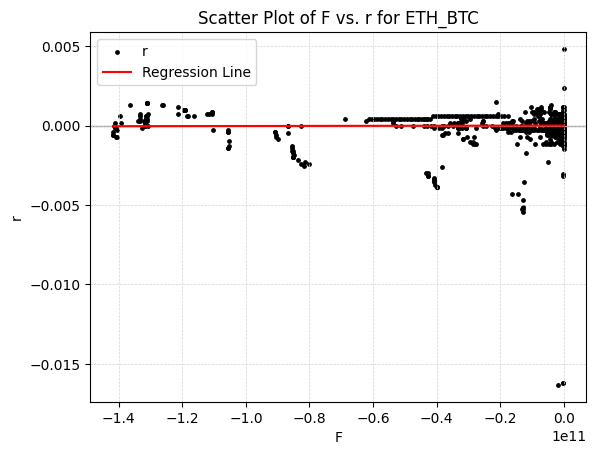

In [581]:
F_tau = trades_ETH_BTC_agg_test['F_tau']
returns = trades_ETH_BTC_agg_test['forward_return']

# Create the scatter plot
plt.scatter(F_tau, returns, label='r', color='black', s=6)

# Compute the line points based on the beta coefficient
Fmin_ETH_BTC = F_tau.min()
Fmax_ETH_BTC = F_tau.max()
beta_ETH_BTC = beta_ETH_BTC_agg_train 
line_points_x = [Fmin_ETH_BTC, Fmax_ETH_BTC]
line_points_y = [Fmin_ETH_BTC * beta_ETH_BTC, Fmax_ETH_BTC * beta_ETH_BTC]

plt.plot(line_points_x, line_points_y, color='red', label='Regression Line')

plt.axhspan(-j, j, color='gray', alpha=0.8)

plt.xlabel('F')
plt.ylabel('r')
plt.title('Scatter Plot of F vs. r for ETH_BTC')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
plt.show()

From the graph, it can be appreciated a relatively flat regression line, suggesting little to no linear relationship between trade flow and returns. The data points are widely spread out along the y-axis, indicating high variance in returns that is not correctly explained by the trade flow. This suggests that the relationship between the trade flow and returns is non-linear and influenced by other factors not included in the model.

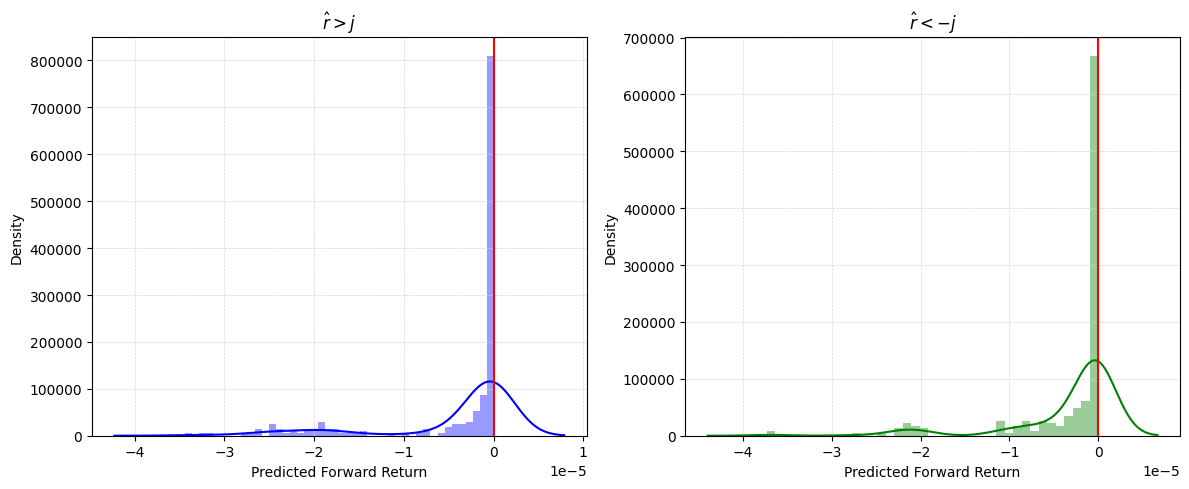

In [582]:
# Condition where predicted forward returns > j
r_condition_ETH_BTC_pos = trades_ETH_BTC_agg_train[trades_ETH_BTC_agg_train['forward_return'] > j]['predicted forward returns']

# Condition where predicted forward returns < -j
r_condition_ETH_BTC_neg = trades_ETH_BTC_agg_train[trades_ETH_BTC_agg_train['forward_return'] < -j]['predicted forward returns']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot for condition where predicted forward returns > j
sns.distplot(r_condition_ETH_BTC_pos, ax=axs[0], color='blue')
axs[0].axvline(0, c='r')
axs[0].set_title(r'$\hat{r} > j$')
axs[0].set_xlabel('Predicted Forward Return')
axs[0].set_ylabel('Density')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# Plot for condition where predicted forward returns < -j
sns.distplot(r_condition_ETH_BTC_neg, ax=axs[1], color='green')
axs[1].axvline(0, c='r')
axs[1].set_title('$\hat{r} < -j$')
axs[1].set_xlabel('Predicted Forward Return')
axs[1].set_ylabel('Density')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

plt.tight_layout()
plt.show()

# 4. Analysis

Assess the trading opportunities arising from using these return predictions in your test set, both with and without trading cost assumptions. Examine Sharpe ratios, drawdowns and tails. As part of this assessment, comment on the reliability/stability of $\beta$ (most easily done by further splitting the data set), how you chose $j$, and what you might expect from using much longer training and test periods.

**Prediction**

After the regression, we use the left 60% data to be the testing set and use the coefficient we get from the regression to do the prediction of the return.

Then, compute the daily pnl and cumulative pnl to see the returns.

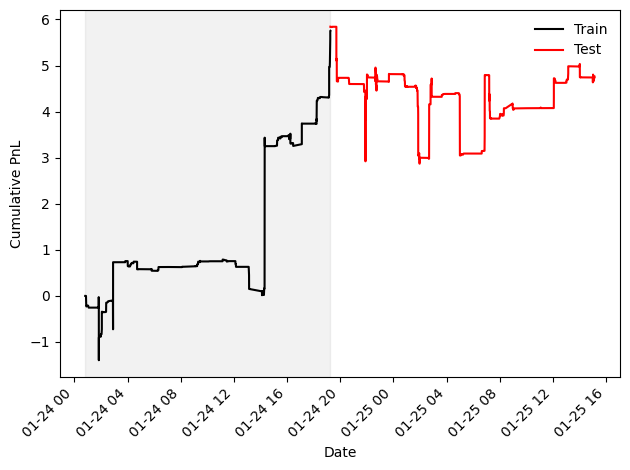

In [583]:
## ETH_BTC ##

# Check if 'timestamp_utc_nanoseconds' exists and convert it to datetime only if it does
if 'timestamp_utc_nanoseconds' in trades_ETH_BTC_agg_train.columns:
    trades_ETH_BTC_agg_train['timestamp'] = pd.to_datetime(trades_ETH_BTC_agg_train['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_BTC_agg_train.set_index('timestamp', inplace=True)

if 'timestamp_utc_nanoseconds' in trades_ETH_BTC_agg_test.columns:
    trades_ETH_BTC_agg_test['timestamp'] = pd.to_datetime(trades_ETH_BTC_agg_test['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_BTC_agg_test.set_index('timestamp', inplace=True)

T = 10 # seconds
T = pd.to_timedelta(T, unit='s')
mean_diff_ns = trades_ETH_BTC_agg_test.index.to_series().diff().mean()
mean_diff_timedelta = pd.to_timedelta(mean_diff_ns)
scaler_ETH_BTC = T.total_seconds() / mean_diff_timedelta.total_seconds()

# Calculate the Position and PnL for the training set
pnl_train_ETH_BTC = trades_ETH_BTC_agg_train['Position'] / scaler_ETH_BTC
cumpnl_train_ETH_BTC = pnl_train_ETH_BTC.cumsum()
cumpnl_train_ETH_BTC.plot(color='k', label='Train')

# Calculate the Position and PnL for the testing set
pnl_test_ETH_BTC = trades_ETH_BTC_agg_test['Position'] / scaler_ETH_BTC
cumpnl_test_ETH_BTC = pnl_test_ETH_BTC.cumsum()
(cumpnl_test_ETH_BTC + cumpnl_train_ETH_BTC.iloc[-1]).plot(color='r', label='Test')

plt.axvspan(trades_ETH_BTC_agg_train.index[0], trades_ETH_BTC_agg_train.index[-1], color='gray', alpha=0.1)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(frameon=False)
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')  # Explicitly set the x-axis label
plt.tight_layout()
plt.show()



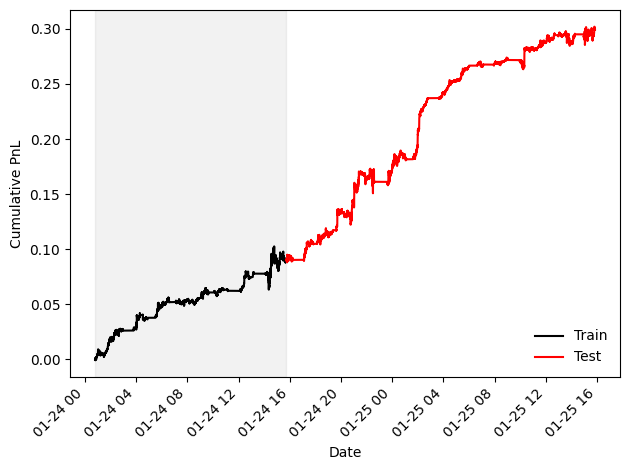

In [619]:
## BTC_USD ##

# Check if 'timestamp_utc_nanoseconds' exists and convert it to datetime only if it does
if 'timestamp_utc_nanoseconds' in trades_BTC_USD_agg_train.columns:
    trades_BTC_USD_agg_train['timestamp'] = pd.to_datetime(trades_BTC_USD_agg_train['timestamp_utc_nanoseconds'], unit='ns')
    trades_BTC_USD_agg_train.set_index('timestamp', inplace=True)

if 'timestamp_utc_nanoseconds' in trades_BTC_USD_agg_test.columns:
    trades_BTC_USD_agg_test['timestamp'] = pd.to_datetime(trades_BTC_USD_agg_test['timestamp_utc_nanoseconds'], unit='ns')
    trades_BTC_USD_agg_test.set_index('timestamp', inplace=True)

T = 10 # seconds
T = pd.to_timedelta(T, unit='s')
mean_diff_ns = trades_BTC_USD_agg_test.index.to_series().diff().mean()
mean_diff_timedelta = pd.to_timedelta(mean_diff_ns)
scaler_BTC_USD = T.total_seconds() / mean_diff_timedelta.total_seconds()

# Calculate the Position and PnL for the training set
pnl_train_BTC_USD = trades_BTC_USD_agg_train['Position'] / scaler_BTC_USD
cumpnl_train_BTC_USD = pnl_train_BTC_USD.cumsum()
cumpnl_train_BTC_USD.plot(color='k', label='Train')

# Calculate the Position and PnL for the testing set
pnl_test_BTC_USD = trades_BTC_USD_agg_test['Position'] / scaler_BTC_USD
cumpnl_test_BTC_USD = pnl_test_BTC_USD.cumsum()
(cumpnl_test_BTC_USD + cumpnl_train_BTC_USD.iloc[-1]).plot(color='r', label='Test')

plt.axvspan(trades_BTC_USD_agg_train.index[0], trades_BTC_USD_agg_train.index[-1], color='gray', alpha=0.1)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(frameon=False)
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')  # Explicitly set the x-axis label
plt.tight_layout()
plt.show()


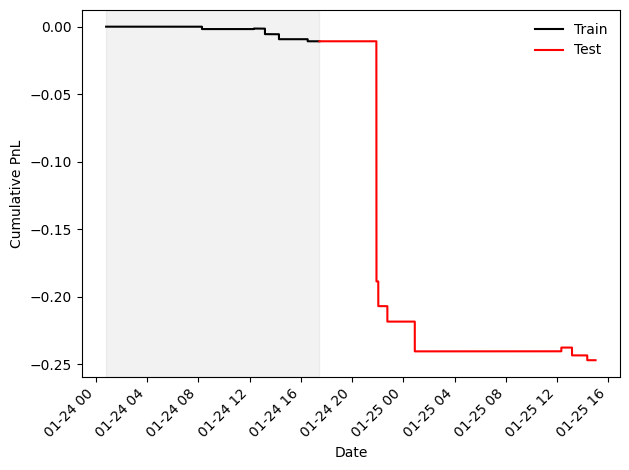

In [652]:
## ETH_USD ##

# Check if 'timestamp_utc_nanoseconds' exists and convert it to datetime only if it does
if 'timestamp_utc_nanoseconds' in trades_ETH_USD_agg_train.columns:
    trades_ETH_USD_agg_train['timestamp'] = pd.to_datetime(trades_ETH_USD_agg_train['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_USD_agg_train.set_index('timestamp', inplace=True)

if 'timestamp_utc_nanoseconds' in trades_ETH_USD_agg_test.columns:
    trades_ETH_USD_agg_test['timestamp'] = pd.to_datetime(trades_ETH_USD_agg_test['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_USD_agg_test.set_index('timestamp', inplace=True)

T = 10 # seconds
T = pd.to_timedelta(T, unit='s')
mean_diff_ns = trades_ETH_USD_agg_test.index.to_series().diff().mean()
mean_diff_timedelta = pd.to_timedelta(mean_diff_ns)
scaler_ETH_USD = T.total_seconds() / mean_diff_timedelta.total_seconds()

# Calculate the Position and PnL for the training set
pnl_train_ETH_USD = trades_ETH_USD_agg_train['Position'] / scaler_ETH_USD
cumpnl_train_ETH_USD = pnl_train_ETH_USD.cumsum()
cumpnl_train_ETH_USD.plot(color='k', label='Train')

# Calculate the Position and PnL for the testing set
pnl_test_ETH_USD = trades_ETH_USD_agg_test['Position'] / scaler_ETH_USD
cumpnl_test_ETH_USD = pnl_test_ETH_USD.cumsum()
(cumpnl_test_ETH_USD + cumpnl_train_ETH_USD.iloc[-1]).plot(color='r', label='Test')

plt.axvspan(trades_ETH_USD_agg_train.index[0], trades_ETH_USD_agg_train.index[-1], color='gray', alpha=0.1)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(frameon=False)
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')  # Explicitly set the x-axis label
plt.tight_layout()
plt.show()

The following metrics will be computed to judge the efficacy of the strategy:

1. **Sharpe Ratio**: The Sharpe Ratio measures the risk-adjusted return of an investment. It quantifies the excess return generated per unit of risk taken. A higher Sharpe Ratio indicates a better risk-adjusted return, implying that the strategy is delivering higher returns relative to the amount of risk assumed.

2. **Maximum Drawdown**: Maximum Drawdown represents the maximum observed loss from a peak to a trough during a specific period. It provides insight into the strategy's worst-case scenario in terms of loss magnitude. A smaller Maximum Drawdown suggests that the strategy has been more resilient to significant downturns and is less prone to large losses.

3. **Winning Rate**: The Winning Rate measures the percentage of winning trades relative to the total number of trades executed. It provides a measure of the strategy's consistency and ability to generate profitable trades. A higher Winning Rate indicates that the strategy has a greater proportion of successful trades, potentially contributing to overall profitability.

In [584]:
def sharpe(x):
    x = x.resample('1min').mean()  # resample to 1min to calculate sharpe ratio
    return (252 * 24 * 60)**0.5 * x.mean() / (x.std() if x.std() else np.nan)

def win_rate(x):
    return sum(x > 0) / (sum(x != 0) if any(x != 0) else np.nan)

def maximum_drawdown(x):
    return (x.cummax() - x).max()

In [585]:
# Performance metrics for ETH_BTC
print(f'train: sharpe={sharpe(pnl_train_ETH_BTC):.2f}, win%={win_rate(pnl_train_ETH_BTC):.2%}, mdd={maximum_drawdown(cumpnl_train_ETH_BTC):.2f}')
print(f'test: sharpe={sharpe(pnl_test_ETH_BTC):.2f}, win%={win_rate(pnl_test_ETH_BTC):.2%}, mdd={maximum_drawdown(cumpnl_test_ETH_BTC):.2f}')

train: sharpe=44.73, win%=52.87%, mdd=1.40
test: sharpe=12.57, win%=46.55%, mdd=2.97


In [620]:
# Performance metrics for BTC_USD
print(f'train: sharpe={sharpe(pnl_train_BTC_USD):.2f}, win%={win_rate(pnl_train_BTC_USD):.2%}, mdd={maximum_drawdown(cumpnl_train_BTC_USD):.2f}')
print(f'test: sharpe={sharpe(pnl_test_BTC_USD):.2f}, win%={win_rate(pnl_test_BTC_USD):.2%}, mdd={maximum_drawdown(cumpnl_test_BTC_USD):.2f}')

train: sharpe=87.18, win%=51.06%, mdd=0.02
test: sharpe=95.54, win%=50.89%, mdd=0.02


In [653]:
# Performance metrics for ETH_USD
print(f'train: sharpe={sharpe(pnl_train_ETH_USD):.2f}, win%={win_rate(pnl_train_ETH_USD):.2%}, mdd={maximum_drawdown(cumpnl_train_ETH_USD):.2f}')
print(f'test: sharpe={sharpe(pnl_test_ETH_USD):.2f}, win%={win_rate(pnl_test_ETH_USD):.2%}, mdd={maximum_drawdown(cumpnl_test_ETH_USD):.2f}')

train: sharpe=-51.65, win%=0.75%, mdd=0.01
test: sharpe=-50.99, win%=7.87%, mdd=0.24


**Parameter Tuning**

Clearly, choosing thresholds by hands is not working here. It’s not efficient. More importantly, it’s not gonna help us find the best strategy. That’s why we should do the parameter tuning here. We should use training dataset to do the parameter tuning since the prediction part is where we use the strategy to predict, if we use predict dataset, then we’re using forward information, which doesn’t make sense when it comes to the real world situation.

**ETH_BTC**

The best j is 3.0000000000000004e-05.
The Sharpe Ratio of the strategy is 37.64038158105355.
The winning rate of the strategy is 40.00%
The maximum drawdown of the strategy is 0.00


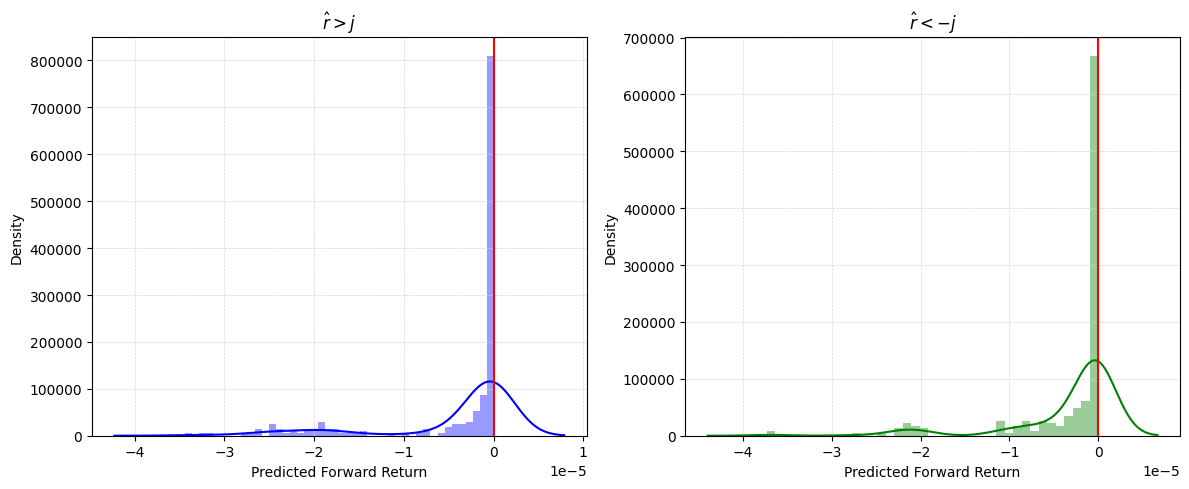

In [586]:
max_sharpe_ETH_BTC = -float('inf')
best_j_ETH_BTC = None
win_rate_best_ETH_BTC = None
mmd_best_ETH_BTC = None
best_cumpnl_ETH_BTC = None

T = pd.to_timedelta(10, unit='s') 

for j in np.arange(0.00001, 0.0031, 0.00001):
    # Calculate 'Position' for the given threshold j
    trades_ETH_BTC_agg_train['Position'] = np.where(np.abs(trades_ETH_BTC_agg_train['predicted forward returns']) > j, 
                                                    np.sign(trades_ETH_BTC_agg_train['predicted forward returns']) * trades_ETH_BTC_agg_train['Size'] * portion, 
                                                    0)
    
    # Calculate PnL based on 'Position' and actual 'forward_return'
    pnl = trades_ETH_BTC_agg_train['Position'] * trades_ETH_BTC_agg_train['forward_return'] / scaler_ETH_BTC
    cumpnl = pnl.cumsum()
    
    # Calculate Sharpe Ratio for the current j
    sharpe_ratio = sharpe(pnl)
    if sharpe_ratio > max_sharpe_ETH_BTC:
        max_sharpe_ETH_BTC = sharpe_ratio
        best_j_ETH_BTC = j
        win_rate_best_ETH_BTC = win_rate(pnl)
        mmd_best_ETH_BTC = maximum_drawdown(cumpnl)
        best_cumpnl_ETH_BTC = cumpnl

print(f'The best j is {best_j_ETH_BTC}.')
print(f'The Sharpe Ratio of the strategy is {max_sharpe_ETH_BTC}.')
print(f'The winning rate of the strategy is {win_rate_best_ETH_BTC:.2%}')
print(f'The maximum drawdown of the strategy is {mmd_best_ETH_BTC:.2f}')

# Condition where predicted forward returns > j
r_condition_ETH_BTC_pos = trades_ETH_BTC_agg_train[trades_ETH_BTC_agg_train['forward_return'] > best_j_ETH_BTC]['predicted forward returns']

# Condition where predicted forward returns < -j
r_condition_ETH_BTC_neg = trades_ETH_BTC_agg_train[trades_ETH_BTC_agg_train['forward_return'] < -best_j_ETH_BTC]['predicted forward returns']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot for condition where predicted forward returns > j
sns.distplot(r_condition_ETH_BTC_pos, ax=axs[0], color='blue')
axs[0].axvline(0, c='r')
axs[0].set_title(r'$\hat{r} > j$')
axs[0].set_xlabel('Predicted Forward Return')
axs[0].set_ylabel('Density')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

# Plot for condition where predicted forward returns < -j
sns.distplot(r_condition_ETH_BTC_neg, ax=axs[1], color='green')
axs[1].axvline(0, c='r')
axs[1].set_title('$\hat{r} < -j$')
axs[1].set_xlabel('Predicted Forward Return')
axs[1].set_ylabel('Density')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

plt.tight_layout()
plt.show()

In [588]:
trades_ETH_BTC_agg_test['Best Position'] = np.where(np.abs(trades_ETH_BTC_agg_test['forward_return']) > best_j_ETH_BTC, np.sign(trades_ETH_BTC_agg_test['forward_return']) * trades_ETH_BTC_agg_test['Size'] * portion, 0)
trades_ETH_BTC_agg_train['Best Position'] = np.where(np.abs(trades_ETH_BTC_agg_train['forward_return']) > best_j_ETH_BTC, np.sign(trades_ETH_BTC_agg_train['forward_return']) * trades_ETH_BTC_agg_train['Size'] * portion, 0)

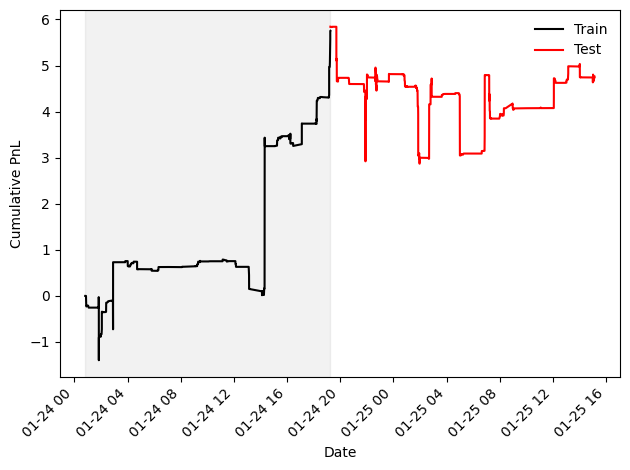

Final PnL for ETH_BTC: 4.76


In [614]:
# Check if 'timestamp_utc_nanoseconds' exists and convert it to datetime only if it does
if 'timestamp_utc_nanoseconds' in trades_ETH_BTC_agg_train.columns:
    trades_ETH_BTC_agg_train['timestamp'] = pd.to_datetime(trades_ETH_BTC_agg_train['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_BTC_agg_train.set_index('timestamp', inplace=True)

if 'timestamp_utc_nanoseconds' in trades_ETH_BTC_agg_test.columns:
    trades_ETH_BTC_agg_test['timestamp'] = pd.to_datetime(trades_ETH_BTC_agg_test['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_BTC_agg_test.set_index('timestamp', inplace=True)

T = 10 # seconds
T = pd.to_timedelta(T, unit='s')
mean_diff_ns = trades_ETH_BTC_agg_test.index.to_series().diff().mean()
mean_diff_timedelta = pd.to_timedelta(mean_diff_ns)
scaler_ETH_BTC = T.total_seconds() / mean_diff_timedelta.total_seconds()

# Calculate the Position and PnL for the training set
pnl_train_ETH_BTC = trades_ETH_BTC_agg_train['Best Position'] / scaler_ETH_BTC
cumpnl_train_ETH_BTC = pnl_train_ETH_BTC.cumsum()
cumpnl_train_ETH_BTC.plot(color='k', label='Train')

# Calculate the Position and PnL for the testing set
pnl_test_ETH_BTC = trades_ETH_BTC_agg_test['Best Position'] / scaler_ETH_BTC
cumpnl_test_ETH_BTC = pnl_test_ETH_BTC.cumsum()
(cumpnl_test_ETH_BTC + cumpnl_train_ETH_BTC.iloc[-1]).plot(color='r', label='Test')

plt.axvspan(trades_ETH_BTC_agg_train.index[0], trades_ETH_BTC_agg_train.index[-1], color='gray', alpha=0.1)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(frameon=False)
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')  # Explicitly set the x-axis label
plt.tight_layout()
plt.show()

print(f'Final PnL for ETH_BTC: {(cumpnl_test_ETH_BTC.iloc[-1] + cumpnl_train_ETH_BTC.iloc[-1]).round(2)}')

In [592]:
RMSE_ETH_BTC = np.sqrt(mean_squared_error(trades_ETH_BTC_agg_train['forward_return'], trades_ETH_BTC_agg_train['predicted forward returns']))
MAE_ETH_BTC = np.mean(np.abs(trades_ETH_BTC_agg_train['forward_return'] - trades_ETH_BTC_agg_train['predicted forward returns']))

In [602]:
n = trades_ETH_BTC_agg.shape[0]
p = trades_ETH_BTC_agg_train.shape[0]

# Adjusted R^2 function
def calculate_adjusted_r_squared(r_squared, n, p):
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    return adjusted_r_squared

adjusted_r_squared_ETH_BTC = calculate_adjusted_r_squared(regression_info_ETH_BTC_agg['r_squared'], n, p)


**BTC_USD**

In [636]:
max_sharpe_BTC_USD = -float('inf')
best_j_BTC_USD = None
win_rate_best_BTC_USD = None
mmd_best_BTC_USD = None
best_cumpnl_BTC_USD = None

T = pd.to_timedelta(10, unit='s') 

for j in np.arange(0.00001, 0.0031, 0.00001):
    # Calculate 'Position' for the given threshold j
    trades_BTC_USD_agg_train['Position'] = np.where(np.abs(trades_BTC_USD_agg_train['predicted forward returns']) > j, 
                                                    np.sign(trades_BTC_USD_agg_train['predicted forward returns']) * trades_BTC_USD_agg_train['Size'] * portion, 
                                                    0)
    
    # Calculate PnL based on 'Position' and actual 'forward_return'
    pnl = trades_BTC_USD_agg_train['Position'] * trades_BTC_USD_agg_train['forward_return'] / scaler_BTC_USD
    cumpnl = pnl.cumsum()
    
    # Calculate Sharpe Ratio for the current j
    sharpe_ratio = sharpe(pnl)
    if sharpe_ratio > max_sharpe_BTC_USD:
        max_sharpe_BTC_USD = sharpe_ratio
        best_j_BTC_USD = j
        win_rate_best_BTC_USD = win_rate(pnl)
        mmd_best_BTC_USD = maximum_drawdown(cumpnl)
        best_cumpnl_BTC_USD = cumpnl

print(f'The best j is {best_j_BTC_USD}.')
print(f'The Sharpe Ratio of the strategy is {max_sharpe_BTC_USD}.')
print(f'The winning rate of the strategy is {win_rate_best_BTC_USD:.2%}')
print(f'The maximum drawdown of the strategy is {mmd_best_BTC_USD:.2f}')

The best j is 1e-05.
The Sharpe Ratio of the strategy is -22.279361906347887.
The winning rate of the strategy is 25.47%
The maximum drawdown of the strategy is 0.00


In [637]:
trades_BTC_USD_agg_test['Best Position'] = np.where(np.abs(trades_BTC_USD_agg_test['forward_return']) > best_j_BTC_USD, np.sign(trades_BTC_USD_agg_test['forward_return']) * trades_BTC_USD_agg_test['Size'] * portion, 0)
trades_BTC_USD_agg_train['Best Position'] = np.where(np.abs(trades_BTC_USD_agg_train['forward_return']) > best_j_BTC_USD, np.sign(trades_BTC_USD_agg_train['forward_return']) * trades_BTC_USD_agg_train['Size'] * portion, 0)

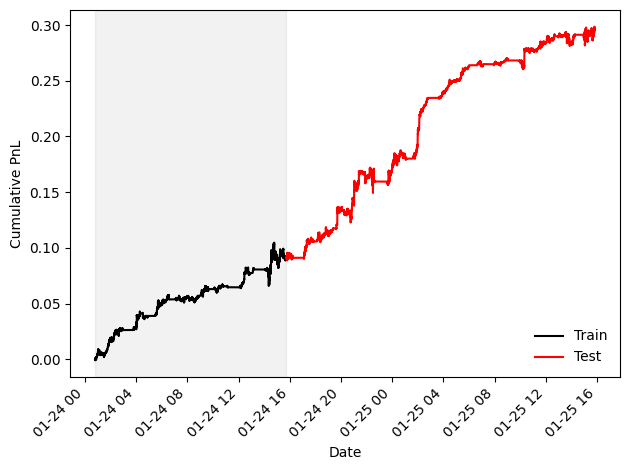

Final PnL for BTC_USD: 0.3


In [638]:
# Check if 'timestamp_utc_nanoseconds' exists and convert it to datetime only if it does
if 'timestamp_utc_nanoseconds' in trades_BTC_USD_agg_train.columns:
    trades_BTC_USD_agg_train['timestamp'] = pd.to_datetime(trades_BTC_USD_agg_train['timestamp_utc_nanoseconds'], unit='ns')
    trades_BTC_USD_agg_train.set_index('timestamp', inplace=True)

if 'timestamp_utc_nanoseconds' in trades_BTC_USD_agg_test.columns:
    trades_BTC_USD_agg_test['timestamp'] = pd.to_datetime(trades_BTC_USD_agg_test['timestamp_utc_nanoseconds'], unit='ns')
    trades_BTC_USD_agg_test.set_index('timestamp', inplace=True)

T = 10 # seconds
T = pd.to_timedelta(T, unit='s')
mean_diff_ns = trades_BTC_USD_agg_test.index.to_series().diff().mean()
mean_diff_timedelta = pd.to_timedelta(mean_diff_ns)
scaler_BTC_USD = T.total_seconds() / mean_diff_timedelta.total_seconds()

# Calculate the Position and PnL for the training set
pnl_train_BTC_USD = trades_BTC_USD_agg_train['Best Position'] / scaler_BTC_USD
cumpnl_train_BTC_USD = pnl_train_BTC_USD.cumsum()
cumpnl_train_BTC_USD.plot(color='k', label='Train')

# Calculate the Position and PnL for the testing set
pnl_test_BTC_USD = trades_BTC_USD_agg_test['Best Position'] / scaler_BTC_USD
cumpnl_test_BTC_USD = pnl_test_BTC_USD.cumsum()
(cumpnl_test_BTC_USD + cumpnl_train_BTC_USD.iloc[-1]).plot(color='r', label='Test')

plt.axvspan(trades_BTC_USD_agg_train.index[0], trades_BTC_USD_agg_train.index[-1], color='gray', alpha=0.1)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(frameon=False)
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')  # Explicitly set the x-axis label
plt.tight_layout()
plt.show()

print(f'Final PnL for BTC_USD: {(cumpnl_test_BTC_USD.iloc[-1] + cumpnl_train_BTC_USD.iloc[-1]).round(2)}')

In [639]:
RMSE_BTC_USD = np.sqrt(mean_squared_error(trades_BTC_USD_agg_train['forward_return'], trades_BTC_USD_agg_train['predicted forward returns']))
MAE_BTC_USD = np.mean(np.abs(trades_BTC_USD_agg_train['forward_return'] - trades_BTC_USD_agg_train['predicted forward returns']))

In [640]:
n_BTC = trades_BTC_USD_agg.shape[0]
p_BTC = trades_BTC_USD_agg_train.shape[0]

# Adjusted R^2 function
def calculate_adjusted_r_squared(r_squared, n, p):
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    return adjusted_r_squared

adjusted_r_squared_BTC_USD = calculate_adjusted_r_squared(regression_info_BTC_USD_agg['r_squared'], n_BTC, p_BTC)

**ETH_USD**

In [654]:
max_sharpe_ETH_USD = -float('inf')
best_j_ETH_USD = None
win_rate_best_ETH_USD = None
mmd_best_ETH_USD = None
best_cumpnl_ETH_USD = None

T = pd.to_timedelta(10, unit='s') 

for j in np.arange(0.00001, 0.0031, 0.00001):
    # Calculate 'Position' for the given threshold j
    trades_ETH_USD_agg_train['Position'] = np.where(np.abs(trades_ETH_USD_agg_train['predicted forward returns']) > j, 
                                                    np.sign(trades_ETH_USD_agg_train['predicted forward returns']) * trades_ETH_USD_agg_train['Size'] * portion, 
                                                    0)
    
    # Calculate PnL based on 'Position' and actual 'forward_return'
    pnl = trades_ETH_USD_agg_train['Position'] * trades_ETH_USD_agg_train['forward_return'] / scaler_ETH_USD
    cumpnl = pnl.cumsum()
    
    # Calculate Sharpe Ratio for the current j
    sharpe_ratio = sharpe(pnl)
    if sharpe_ratio > max_sharpe_ETH_USD:
        max_sharpe_ETH_USD = sharpe_ratio
        best_j_ETH_USD = j
        win_rate_best_ETH_USD = win_rate(pnl)
        mmd_best_ETH_USD = maximum_drawdown(cumpnl)
        best_cumpnl_ETH_USD = cumpnl

print(f'The best j is {best_j_ETH_USD}.')
print(f'The Sharpe Ratio of the strategy is {max_sharpe_ETH_USD}.')
print(f'The winning rate of the strategy is {win_rate_best_ETH_USD:.2%}')
print(f'The maximum drawdown of the strategy is {mmd_best_ETH_USD:.2f}')

The best j is 1e-05.
The Sharpe Ratio of the strategy is 6.8163992917405585.
The winning rate of the strategy is 55.84%
The maximum drawdown of the strategy is 0.00


In [655]:
trades_ETH_USD_agg_test['Best Position'] = np.where(np.abs(trades_ETH_USD_agg_test['forward_return']) > best_j_ETH_USD, np.sign(trades_ETH_USD_agg_test['forward_return']) * trades_ETH_USD_agg_test['Size'] * portion, 0)
trades_ETH_USD_agg_train['Best Position'] = np.where(np.abs(trades_ETH_USD_agg_train['forward_return']) > best_j_ETH_USD, np.sign(trades_ETH_USD_agg_train['forward_return']) * trades_ETH_USD_agg_train['Size'] * portion, 0)

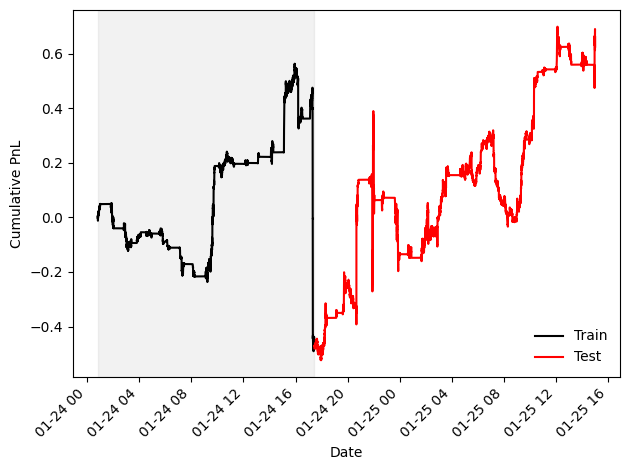

In [656]:
# Check if 'timestamp_utc_nanoseconds' exists and convert it to datetime only if it does
if 'timestamp_utc_nanoseconds' in trades_ETH_USD_agg_train.columns:
    trades_ETH_USD_agg_train['timestamp'] = pd.to_datetime(trades_ETH_USD_agg_train['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_USD_agg_train.set_index('timestamp', inplace=True)

if 'timestamp_utc_nanoseconds' in trades_ETH_USD_agg_test.columns:
    trades_ETH_USD_agg_test['timestamp'] = pd.to_datetime(trades_ETH_USD_agg_test['timestamp_utc_nanoseconds'], unit='ns')
    trades_ETH_USD_agg_test.set_index('timestamp', inplace=True)

T = 10 # seconds
T = pd.to_timedelta(T, unit='s')
mean_diff_ns = trades_ETH_USD_agg_test.index.to_series().diff().mean()
mean_diff_timedelta = pd.to_timedelta(mean_diff_ns)
scaler_ETH_USD = T.total_seconds() / mean_diff_timedelta.total_seconds()

# Calculate the Position and PnL for the training set
pnl_train_ETH_USD = trades_ETH_USD_agg_train['Best Position'] / scaler_ETH_USD
cumpnl_train_ETH_USD = pnl_train_ETH_USD.cumsum()
cumpnl_train_ETH_USD.plot(color='k', label='Train')

# Calculate the Position and PnL for the testing set
pnl_test_ETH_USD = trades_ETH_USD_agg_test['Best Position'] / scaler_ETH_USD
cumpnl_test_ETH_USD = pnl_test_ETH_USD.cumsum()
(cumpnl_test_ETH_USD + cumpnl_train_ETH_USD.iloc[-1]).plot(color='r', label='Test')

plt.axvspan(trades_ETH_USD_agg_train.index[0], trades_ETH_USD_agg_train.index[-1], color='gray', alpha=0.1)

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(frameon=False)
plt.ylabel('Cumulative PnL')
plt.xlabel('Date')  # Explicitly set the x-axis label
plt.tight_layout()
plt.show()

In [657]:
RMSE_ETH_USD = np.sqrt(mean_squared_error(trades_ETH_USD_agg_train['forward_return'], trades_ETH_USD_agg_train['predicted forward returns']))
MAE_ETH_USD = np.mean(np.abs(trades_ETH_USD_agg_train['forward_return'] - trades_ETH_USD_agg_train['predicted forward returns']))

In [658]:
n_ETH = trades_ETH_USD_agg.shape[0]
p_ETH = trades_ETH_USD_agg_train.shape[0]

# Adjusted R^2 function
def calculate_adjusted_r_squared(r_squared, n, p):
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    return adjusted_r_squared

adjusted_r_squared_ETH_USD = calculate_adjusted_r_squared(regression_info_BTC_USD_agg['r_squared'], n_ETH, p_ETH)

# 5. Conclusions

**Reliability of $\beta$ of regression model**

To evaluate the reliability and accuracy of a regression model comprehensively, various statistical metrics could be utilized, each offering unique insights into the model's performance:

1. **Adjusted $R^2$**: While $R^2$ quantifies the percentage of the dependent variable's variance that is explained by the independent variable(s), Adjusted \(R^2\) refines this measure by adjusting for the number of predictors in the model. This adjustment prevents overestimation of the model's explanatory power, especially with multiple predictors. Higher values suggest a better fit, making the model more reliable for predictions.

2. **RMSE (Root Mean Square Error)**: RMSE measures the standard deviation of the residuals or prediction errors, indicating how closely the model's predicted values match the actual observed outcomes. A lower RMSE signifies a closer fit to the data, enhancing the model's reliability.

3. **MAE (Mean Absolute Error)**: Similar to RMSE, MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It provides a straightforward metric of average error magnitude. Like RMSE, a lower MAE indicates a better model fit.

**ETH_BTC**

In [603]:
print(f'RMSE for ETH_BTC: {RMSE_ETH_BTC:.5f}')
print(f'MAE for ETH_BTC: {MAE_ETH_BTC:.5f}')
print(f'Adjusted R^2 for ETH_BTC: {adjusted_r_squared_ETH_BTC:.2f}')

RMSE for ETH_BTC: 0.00041
MAE for ETH_BTC: 0.00021
Adjusted R^2 for ETH_BTC: -0.67


A RMSE of 0.00041 suggests that, on average, the model's predictions are within 0.00041 units from the actual data points, a RMSE of this magnitude might be considered low and thus indicative of a relatively good fit. 

Regarding the value of the MAE, a MAE of 0.00021 indicates that, on average, the model's predictions are 0.00021 units away from the actual values. The fact that MAE is about half of RMSE suggests that there are not many large errors skewing the average, as RMSE gives more weight to larger errors than MAE.

However, an adjusted $R^2$ of -0.67 is highly unusual and suggests that the model is not capturing the underlying pattern between the predictors and the target variable, essentially performing worse than a simple model that always predicts the average of the target.

**BTC_USD**

In [641]:
print(f'RMSE for BTC_USD: {RMSE_BTC_USD:.5f}')
print(f'MAE for BTC_USD: {MAE_BTC_USD:.5f}')

print(f'Adjusted R^2 for BTC_USD: {adjusted_r_squared_BTC_USD:.2f}')

RMSE for BTC_USD: 0.00033
MAE for BTC_USD: 0.00020
Adjusted R^2 for BTC_USD: -0.67


**ETH_USD**

In [660]:
print(f'RMSE for ETH_USD: {RMSE_ETH_USD:.5f}')
print(f'MAE for ETH_USD: {MAE_ETH_USD:.5f}')

print(f'Adjusted R^2 for ETH_USD: {adjusted_r_squared_ETH_USD:.2f}')

RMSE for ETH_USD: 0.00036
MAE for ETH_USD: 0.00020
Adjusted R^2 for ETH_USD: -0.67


**How to choose $j$ in this strategy?**

Selecting the appropriate threshold $j$ is crucial for optimizing our trading strategy based on the predicted returns $r$. The objective is to set $j$ so that the distribution of $r$ exhibits desired skewness characteristics—left-skewed for $r > j$ and right-skewed for $r < -j$. This approach aims to capitalize on predictive insights into market movements. However, it's essential to strike a balance with the threshold $j$:

- **Avoiding Excessively High $j$**: A threshold that's too high may result in missed trading opportunities. If $j$ is set significantly above typical fluctuations, the strategy might become overly conservative, rarely triggering trades only in extreme conditions that may not offer the best risk-reward ratio.

- **Preventing Overly Low $j$**: Conversely, a very low $j$ diminishes the threshold's purpose, potentially leading to frequent but insignificant trades. This "noise" can erode profitability through trading costs and may not substantially improve the strategy's effectiveness.

In an initial experiment with $j = 2 * 1e-06$, distribution analysis of $r$ revealed it did not align with our strategic expectations—highlighting the importance of careful threshold selection. Subsequent parameter tuning efforts, guided by distributional analysis, allowed for an adjustment of $j$ that yielded distributions more in line with strategic goals. This iterative process underscores the significance of empirical analysis in refining trading parameters to better capture predictive advantages while managing risk and opportunity frequency.

**How would the prediction get affected if the training and testing period varied?**

In the context of cryptocurrency trading, varying the training and testing periods can significantly affect the predictions of a trading model for several reasons. Cryptocurrency markets are known for their high volatility compared to traditional financial markets. A model trained on a period of relative stability might perform poorly when tested in a highly volatile period, and vice versa. The model's ability to generalize might be compromised if it hasn't been exposed to a wide range of market conditions.

Cryptocurrency markets exhibit trends and cycles, such as bull and bear markets, which can last from weeks to years. Training and testing the model on periods that capture different phases of these cycles can affect its predictive accuracy. A model trained during a bull market might not predict well in a bear market due to the shift in underlying market dynamics. Hence, training a model on a very specific period may lead to overfitting, where the model learns the noise specific to that period rather than the underlying market patterns. This can reduce the model's ability to generalize and perform accurately in unseen market conditions.

To sum up, with much longer training and test period, the strategy will become less reliable and the return will be much less attempting.